# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [38]:
# %pip install fsspec
# %pip install pyarrow
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install openpyxl
# %pip install pyspark -i https://mirrors.aliyun.com/pypi/simple/

In [39]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
from  openpyxl import load_workbook
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
from pyspark.sql.functions import split, col
from pyspark.sql.functions import col




In [40]:
from pyspark.sql import SparkSession
from pyspark.pandas.plot.matplotlib import plot_pandas_on_spark

#创建 SparkSession
# spark = SparkSession.builder \
#     .appName("Read HDFS File") \
#     .config("spark.submit.deployMode", "client") \
#     .config("spark.driver.memory","4g")\
#     .config("spark.executor.memory","8g")\
#     .master("local[2]") \
#     .config("spark.executor.cores","4")\
#     .config("spark.executor.instances","5")\
#     .getOrCreate()

# spark = SparkSession.builder \
#     .appName("Read HDFS File") \
#     .master("yarn") \
#     .getOrCreate()
# 创建 SparkSession
spark = SparkSession.builder \
    .appName("Read HDFS File") \
    .master("local[*]")\
    .config("spark.dynamicAllocation.enabled", "True")\
    .config("spark.driver.memory","4g")\
    .config("spark.executor.memory","8g")\
    .config("spark.dynamicAllocation.minExecutors", "2")\
    .config("spark.dynamicAllocation.maxExecutors", "8")\
    .getOrCreate()




In [41]:
import pyspark
df = spark.read.csv('hdfs://:192168.1.202:90000/user/hdfs/data1.csv', header=True, inferSchema=True)
# 显示数据
df.show()
df.count()

# 显示数据


+--------------------+--------------------------------+------------+------------+-----------------------------------+---------------------------------------+----+--------+----------------------------------+--------+-----------+----------+------------+-------------+-------------------------------------+------------------------------------+
|                 url|                    company_name|company_size|company_type|                           job_type|                               job_name| edu|empltype|                               tag|  salary|       city|workingexp|resume_count|company_score|                           work_place|                     require_content|
+--------------------+--------------------------------+------------+------------+-----------------------------------+---------------------------------------+----+--------+----------------------------------+--------+-----------+----------+------------+-------------+-------------------------------------+---------------

105152

In [42]:
df = df.drop("tag")
df = df.drop("url")
df.show()

+--------------------------------+------------+------------+-----------------------------------+---------------------------------------+----+--------+--------+-----------+----------+------------+-------------+-------------------------------------+------------------------------------+
|                    company_name|company_size|company_type|                           job_type|                               job_name| edu|empltype|  salary|       city|workingexp|resume_count|company_score|                           work_place|                     require_content|
+--------------------------------+------------+------------+-----------------------------------+---------------------------------------+----+--------+--------+-----------+----------+------------+-------------+-------------------------------------+------------------------------------+
|    深圳市珍爱网信息技术有限公司| 1000-9999人|        合资|            销售业务,大客户销售代表|        大客户销售顾问（六险一金+双休）|中专|    全职|薪资面议|杭州-西湖区|      不限|          83|    316.

In [43]:
df=df.withColumn("city", split(col("city"), "-").getItem(0))
df.show()

+--------------------------------+------------+------------+-----------------------------------+---------------------------------------+----+--------+--------+----+----------+------------+-------------+-------------------------------------+------------------------------------+
|                    company_name|company_size|company_type|                           job_type|                               job_name| edu|empltype|  salary|city|workingexp|resume_count|company_score|                           work_place|                     require_content|
+--------------------------------+------------+------------+-----------------------------------+---------------------------------------+----+--------+--------+----+----------+------------+-------------+-------------------------------------+------------------------------------+
|    深圳市珍爱网信息技术有限公司| 1000-9999人|        合资|            销售业务,大客户销售代表|        大客户销售顾问（六险一金+双休）|中专|    全职|薪资面议|杭州|      不限|          83|    316.07507|               西湖区嘉

In [44]:
df.count()

105152

In [45]:
df = df[df['salary']!= '薪资面议']
df.show()
df.count()

+--------------------------------+------------+------------+-----------------------------------+------------------------------------+----+--------+-------+----+----------+------------+-------------+-------------------------------------+-------------------------------------+
|                    company_name|company_size|company_type|                           job_type|                            job_name| edu|empltype| salary|city|workingexp|resume_count|company_score|                           work_place|                      require_content|
+--------------------------------+------------+------------+-----------------------------------+------------------------------------+----+--------+-------+----+----------+------------+-------------+-------------------------------------+-------------------------------------+
|      好想你健康食品股份有限公司| 1000-9999人|  股份制企业|                  销售业务,销售代表|                        湖南业务代表|不限|    全职|  4K-8K|衡阳|      不限|          56|      315.676|                  

104130

In [46]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import expr, concat, lit, regexp_replace

df = df.withColumn("left_value", (regexp_replace(split(col("salary"), '-').getItem(0), "K", "").cast("int")))
# 提取右边数值，同样先去掉末尾的'k'，再转换为整数类型
df = df.withColumn("right_value", (regexp_replace(split(col("salary"), '-').getItem(1), "K", "").cast("int")))

# 按照要求计算结果，保留一位小数
df = df.withColumn("converted_salary", expr("((left_value + right_value) / 2)").cast("float").alias("result").cast("decimal(10,1)"))
# 格式化为带'k'的字符串，去掉原有的left_value和right_value列（可根据需求保留或删除）
df = df.withColumn("converted_salary", concat(expr("converted_salary"))).drop("left_value", "right_value")
df = df.withColumn("converted_salary", df["converted_salary"].cast(FloatType()))
# 展示转换后的数据
df.show()
# 展示转换后的数据

+--------------------------------+------------+------------+-----------------------------------+------------------------------------+----+--------+-------+----+----------+------------+-------------+-------------------------------------+-------------------------------------+----------------+
|                    company_name|company_size|company_type|                           job_type|                            job_name| edu|empltype| salary|city|workingexp|resume_count|company_score|                           work_place|                      require_content|converted_salary|
+--------------------------------+------------+------------+-----------------------------------+------------------------------------+----+--------+-------+----+----------+------------+-------------+-------------------------------------+-------------------------------------+----------------+
|      好想你健康食品股份有限公司| 1000-9999人|  股份制企业|                  销售业务,销售代表|                        湖南业务代表|不限|    全职|  4K-8K|衡阳|   

In [47]:
df = df.withColumn("type", split(col("job_type"), "/").getItem(0))
df = df.withColumn("type", split(col("type"), ",").getItem(0))
df = df.drop("job_type")

In [48]:
df.describe().show()

+-------+---------------------------+------------+------------+----------------------+------+--------+-------+--------+----------+------------------+------------------+----------------------------------+-----------------------------------+-----------------+--------+
|summary|               company_name|company_size|company_type|              job_name|   edu|empltype| salary|    city|workingexp|      resume_count|     company_score|                        work_place|                    require_content| converted_salary|    type|
+-------+---------------------------+------------+------------+----------------------+------+--------+-------+--------+----------+------------------+------------------+----------------------------------+-----------------------------------+-----------------+--------+
|  count|                     104130|      104129|      104130|                104130|104130|  104130| 104130|  104130|    104130|            104130|            104130|                            104

In [49]:
from pyspark.sql.functions import collect_list
city_df=df.groupBy("city").count()
city_df=city_df.orderBy(city_df["count"].desc())
city_df.show()

+------+-----+
|  city|count|
+------+-----+
|  北京|15951|
|  深圳| 7252|
|  广州| 6278|
|  上海| 5958|
|  西安| 5686|
|  成都| 4724|
|  南京| 4437|
|  杭州| 4036|
|  武汉| 2576|
|  苏州| 2502|
|  长沙| 2247|
|  郑州| 2225|
|  福州| 2053|
|  天津| 2040|
|石家庄| 1843|
|  太原| 1832|
|  济南| 1726|
|  无锡| 1555|
|  青岛| 1462|
|  合肥| 1460|
+------+-----+
only showing top 20 rows



In [50]:
merged_city_df1 = city_df.limit(15).toPandas()
merged_city_df1

,city,count
0,北京,15951
1,深圳,7252
2,广州,6278
3,上海,5958
4,西安,5686
5,成都,4724
6,南京,4437
7,杭州,4036
8,武汉,2576
9,苏州,2502


In [51]:
c_df = df.filter(col("city").isin(['北京', '上海', '广州', '深圳']))
c_df.count()

35439

In [52]:
c_df_count=c_df.groupby("edu").count()
c_df_count1=c_df_count.orderBy("count").toPandas()
c_df_count1


,edu,count
0,高中,8
1,中技,20
2,中专,1217
3,硕士,1563
4,不限,4212
5,本科,12776
6,大专,15643


In [53]:
c_df_bj=c_df.filter(col("city").isin('北京'))
c_df_sh=c_df.filter(col("city").isin('上海'))
c_df_sz=c_df.filter(col("city").isin('深圳'))
c_df_gz=c_df.filter(col("city").isin('广州'))
c_df_count_gz=c_df_gz.groupby("edu").count().toPandas()
c_df_count_sh=c_df_sh.groupby("edu").count().toPandas()
c_df_count_bj=c_df_bj.groupby("edu").count().toPandas()
c_df_count_sz=c_df_sz.groupby("edu").count().toPandas()


In [54]:
c_df_count_bj

,edu,count
0,高中,1
1,大专,4736
2,硕士,1414
3,本科,8560
4,中专,371
5,不限,864
6,中技,5


In [55]:
c_df_count_gz

,edu,count
0,高中,1
1,大专,3622
2,硕士,2
3,本科,674
4,中专,178
5,不限,1797
6,中技,4


In [56]:
c_df_count_sh

,edu,count
0,高中,3
1,大专,3522
2,硕士,146
3,本科,1356
4,中专,175
5,不限,754
6,中技,2


In [57]:
c_df_count_sz

,edu,count
0,高中,3
1,大专,3763
2,硕士,1
3,本科,2186
4,中专,493
5,不限,797
6,中技,9


In [58]:
c_df

DataFrame[company_name: string, company_size: string, company_type: string, job_name: string, edu: string, empltype: string, salary: string, city: string, workingexp: string, resume_count: int, company_score: double, work_place: string, require_content: string, converted_salary: float, type: string]

In [59]:
df.select(col("salary"), col("converted_salary")).show()


+-------+----------------+
| salary|converted_salary|
+-------+----------------+
|  4K-8K|             6.0|
| 8K-15K|            11.5|
| 8K-15K|            11.5|
|  6K-8K|             7.0|
|10K-15K|            12.5|
|10K-15K|            12.5|
|30K-50K|            40.0|
|30K-50K|            40.0|
|20K-35K|            27.5|
|30K-50K|            40.0|
|  3K-4K|             3.5|
|15K-25K|            20.0|
|20K-32K|            26.0|
|10K-15K|            12.5|
|10K-15K|            12.5|
|10K-15K|            12.5|
| 6K-12K|             9.0|
|  4K-6K|             5.0|
| 8K-15K|            11.5|
|  6K-8K|             7.0|
+-------+----------------+
only showing top 20 rows



In [60]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, round as pyspark_round, cast
from pyspark.sql.functions import avg, format_number

salary_result = c_df.groupBy("edu").agg(avg(col("converted_salary"))).orderBy("avg(converted_salary)").toPandas()

salary_result

,edu,avg(converted_salary)
0,中专,4.957683
1,中技,6.700000
2,不限,8.180793
3,高中,8.312500
4,大专,9.019146
5,本科,12.121113
6,硕士,13.520179


In [61]:
cec_df = c_df.select(col("city"), col("edu"), col("converted_salary")).toPandas()

cec_df

,city,edu,converted_salary
0,北京,本科,11.5
1,北京,本科,11.5
2,北京,不限,12.5
3,北京,本科,12.5
4,北京,硕士,40.0
...,...,...,...
35434,广州,大专,11.5
35435,北京,本科,10.5
35436,广州,不限,5.0
35437,北京,大专,11.5


In [62]:
c_df.show()

+--------------------------------+------------+------------+-------------------------------------+----+--------+-------+----+----------+------------+-------------+------------------------------------+------------------------------------+----------------+----------+
|                    company_name|company_size|company_type|                             job_name| edu|empltype| salary|city|workingexp|resume_count|company_score|                          work_place|                     require_content|converted_salary|      type|
+--------------------------------+------------+------------+-------------------------------------+----+--------+-------+----+----------+------------+-------------+------------------------------------+------------------------------------+----------------+----------+
|    北京自如生活资产管理有限公司| 10000人以上|        民营|   储备干部实习生【自如客户服务经理】|本科|    全职| 8K-15K|北京|     3-5年|          22|    315.18033|                    北京各区就近分配|【岗位职责】客户管理：1、通过自如...|            11.5|      客服|
|    

In [63]:
t_df = c_df


In [64]:
t_df.count()

35439

In [65]:
#all
result=df.groupBy("type").count()
result.toPandas()

,type,count
0,销售业务,16325
1,影视,2036
2,销售总监,33
3,旅游,409
4,教育,2630
5,志愿者,1
6,服装,195
7,生物,178
8,物流,1086
9,律师,946


In [66]:
#beishangguangshen
result2 = t_df.groupBy("type").count()
result2.toPandas()

,type,count
0,销售业务,5343
1,影视,826
2,销售总监,10
3,旅游,313
4,教育,916
5,服装,3
6,生物,164
7,律师,463
8,物流,24
9,物业管理,15


In [67]:

computer_df.count()

26887

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

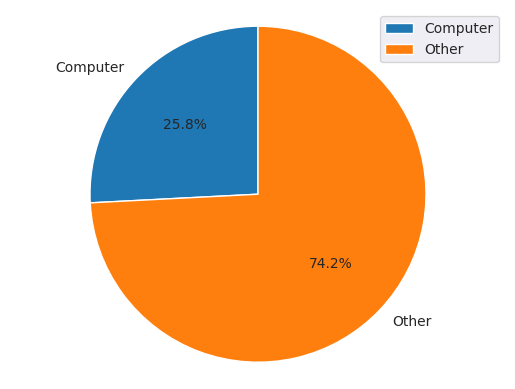

In [68]:
computer_df=df.filter(col("type").isin(['IT管理', '电信', '硬件开发', 'IT质量管理','IT运维','软件','互联网产品','IT管理']))
computer_count=computer_df.count()
other_count=df.count()-computer_count
labels = ['Computer', 'Other']
sizes = [computer_count, other_count]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # 保证饼图是圆形
plt.legend(labels, loc="best")
plt.show()

In [69]:
computer_df1 = computer_df.select(col("workingexp"), col("edu"), col("converted_salary")).toPandas()
computer_df1

,workingexp,edu,converted_salary
0,不限,不限,12.5
1,不限,本科,12.5
2,5-10年,硕士,40.0
3,5-10年,本科,40.0
4,5-10年,本科,27.5
...,...,...,...
26882,1-3年,大专,7.0
26883,3-5年,大专,17.5
26884,3-5年,大专,11.5
26885,3-5年,本科,15.0


In [70]:
from pyspark.sql.functions import count

result3 = computer_df.groupBy("city").agg(count("*").alias("computer_job_count")).toPandas()
result3

,city,computer_job_count
0,阜阳,141
1,南京,1008
2,中卫,2
3,徐州,8
4,临沂,3
...,...,...
100,鞍山,1
101,常州,166
102,武汉,348
103,湖州,1


In [72]:
spark.stop()